# Importing The Libraries

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import warnings
warnings.filterwarnings(action='ignore')
from sklearn.utils import shuffle
import os
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.layers import Flatten ,Dense ,Dropout ,BatchNormalization

# Set Constants

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 128
CHANNELS=3
EPOCHS=10

# Loading The DataSet

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
  "D:\college\Projects\Mask detection\data"  ,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 7553 files belonging to 2 classes.


In [5]:
len(dataset)   

237

In [6]:
class_names = dataset.class_names
class_names

['with_mask', 'without_mask']

# Visualizing The Data

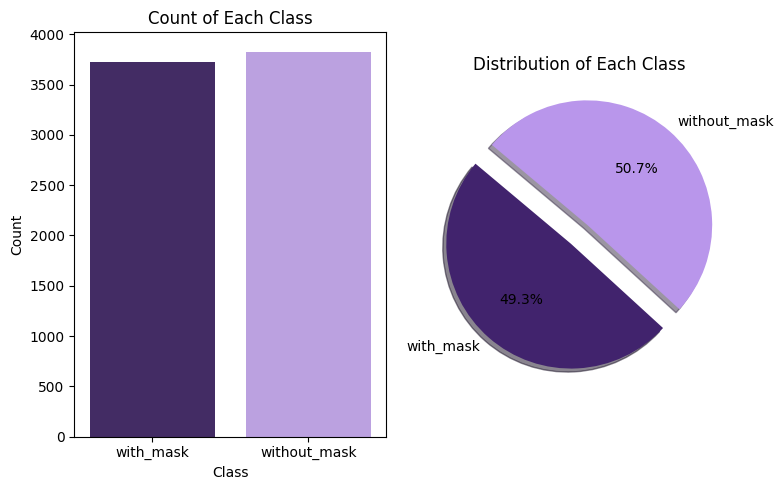

In [7]:
# Function to get all labels from a TensorFlow dataset
def get_all_labels(ds):
    labels = []
    for images_batch, labels_batch in ds:
        if isinstance(labels_batch, tf.Tensor):
            labels.extend(labels_batch.numpy())
        else:
            print("Unexpected format in labels_batch:", type(labels_batch))
    return labels

# Get all labels from the dataset
labels = get_all_labels(dataset)

# Count the occurrences of each class
class_counts = {class_name: 0 for class_name in class_names}
for label in labels:
    class_counts[class_names[label]] += 1

# Create a DataFrame for visualization
df = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Count'])

# Define colors
colors = ['#41236D', '#B996EB']

# Set up the subplots
fig, axes = plt.subplots(1, 2, figsize=(8,5))

# Create count plot using seaborn
sns.barplot(x='Class', y='Count', data=df, palette=colors, ax=axes[0])
axes[0].set_title('Count of Each Class')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')

# Create pie chart using matplotlib
axes[1].pie(df['Count'], labels=df['Class'], autopct='%1.1f%%', startangle=140, colors=colors, shadow=True, explode=[0.1]*len(df))
axes[1].set_title('Distribution of Each Class')

# Show the plots
plt.tight_layout()
plt.show()

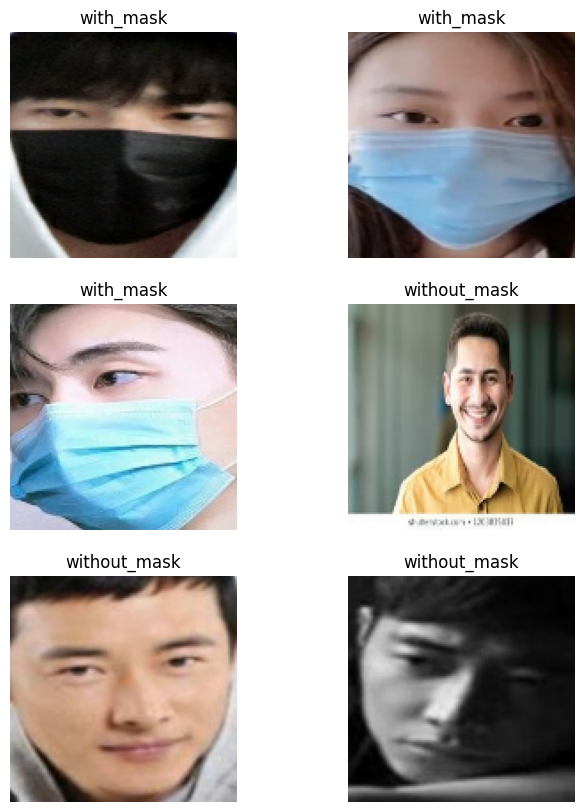

In [8]:
plt.figure(figsize=(8, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(6):
        ax = plt.subplot(3,2, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")   

In [9]:
image_batch[0].shape

TensorShape([128, 128, 3])

# Split Dataset

In [10]:
# | Function to Split Dataset
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)


    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [11]:
print(len(train_ds))         #189+23+25=237
print(len(val_ds))
print(len(test_ds))

189
23
25


In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
from tensorflow.keras import layers
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255),
])

# Modeling

In [14]:
# Define the input shape
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

# Load ResNet152V2 model without top layers and with pre-trained weights
base_model = tf.keras.applications.ResNet152V2(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape
)

# Create a new model
model = Sequential([
    base_model,
    Flatten(),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(rate=0.2),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(rate=0.2),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dropout(rate=0.2),
    Dense(2, activation='sigmoid')  # Assuming binary classification
])

# Compile the model
model.compile(Adamax(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# Test with a dummy input to confirm shapes
dummy_input = tf.keras.Input(shape=input_shape)
model(dummy_input)  # This will help to build the model

<KerasTensor shape=(None, 2), dtype=float32, sparse=False, name=keras_tensor_578>

In [15]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet152v2 (Functional)        │ (None, 4, 4, 2048)     │    58,331,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32768)          │       131,072 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,894,402 (255.18 MB)

 Trainable params: 66,684,354 (254.38 MB)

 Non-trainable params: 210,048 (820.50 KB)

In [16]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 1042s 5s/step - accuracy: 0.8726 - loss: 0.2995 - val_accuracy: 0.9674 - val_loss: 0.0982
Epoch 2/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 956s 5s/step - accuracy: 0.9756 - loss: 0.0812 - val_accuracy: 0.9905 - val_loss: 0.0288
Epoch 3/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 971s 5s/step - accuracy: 0.9923 - loss: 0.0306 - val_accuracy: 0.9905 - val_loss: 0.0299
Epoch 4/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 943s 5s/step - accuracy: 0.9916 - loss: 0.0277 - val_accuracy: 0.9851 - val_loss: 0.0691
Epoch 5/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 920s 5s/step - accuracy: 0.9938 - loss: 0.0214 - val_accuracy: 0.9715 - val_loss: 0.1024
Epoch 6/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 1031s 5s/step - accuracy: 0.9896 - loss: 0.0238 - val_accuracy: 0.9973 - val_loss: 0.0174
Epoch 7/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 1034s 5s/step - accuracy: 0.9978 - loss: 0.0082 - val_accuracy: 0.9973 - val_loss: 0.0207
Epoch 8/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 944s 5s/step - accuracy: 0.9933 - loss: 0.0246 - val_a

# Model Evaluation

In [17]:
scores = model.evaluate(test_ds)

25/25 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9946 - loss: 0.0190


# Plotting the Accuracy and Loss Curves

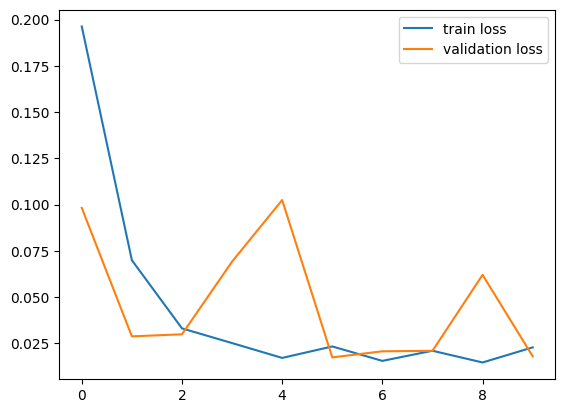

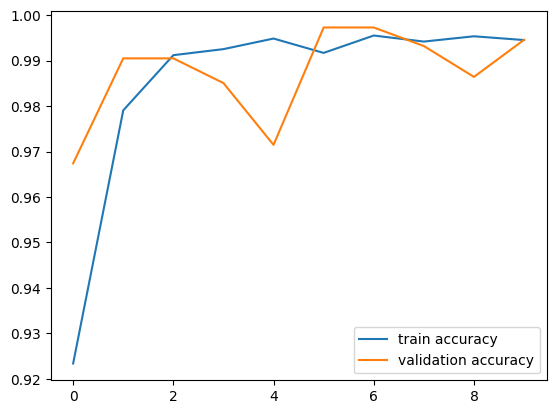

In [18]:
h = history
# plot the loss value
plt.plot(h.history['loss'], 
         label='train loss')
plt.plot(h.history['val_loss'],label='validation loss')
plt.legend()
plt.show()
# plot the accuracy value
plt.plot(h.history['accuracy'], label='train accuracy')
plt.plot(h.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()

# Predict Image

first image to predict
actual label: without_mask
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 981ms/step
predicted label: without_mask


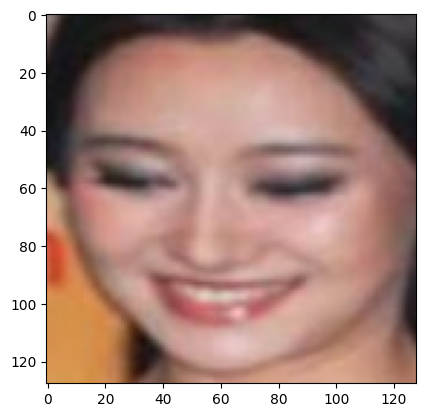

In [32]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [21]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


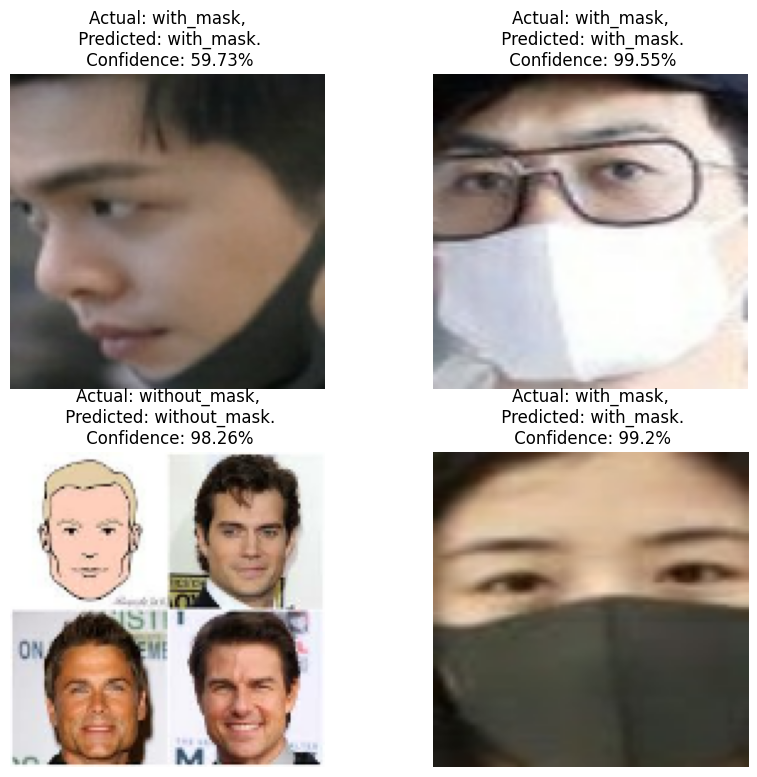

In [36]:
plt.figure(figsize=(10,9))
for images, labels in test_ds.take(1):
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")